# Data loading

In [48]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')

matplotlib.rcParams['figure.figsize'] = [15, 10]

In [49]:
folder = r'./kobe-bryant-shot-selection/'
data = pd.read_csv(folder + 'data.csv')

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [51]:
data.sample(5)

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
15813,Turnaround Bank shot,Bank Shot,332,20900621,34.0023,43,42,-118.2268,5,3,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2010-01-21,LAL @ CLE,CLE,15814
6971,Driving Layup Shot,Layup,224,20400799,34.0443,0,0,-118.2698,1,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2005-02-23,LAL @ POR,POR,6972
13502,Running Bank shot,Bank Shot,522,20800277,34.0113,116,33,-118.1538,0,4,...,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2008-12-05,LAL @ WAS,WAS,13503
12323,Jump Shot,Jump Shot,254,20700643,33.9123,-77,132,-118.3468,11,3,...,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2008-01-27,LAL vs. CLE,CLE,12324
14139,Jump Shot,Jump Shot,359,20800721,33.8443,-79,200,-118.3488,2,3,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2009-02-04,LAL @ TOR,TOR,14140


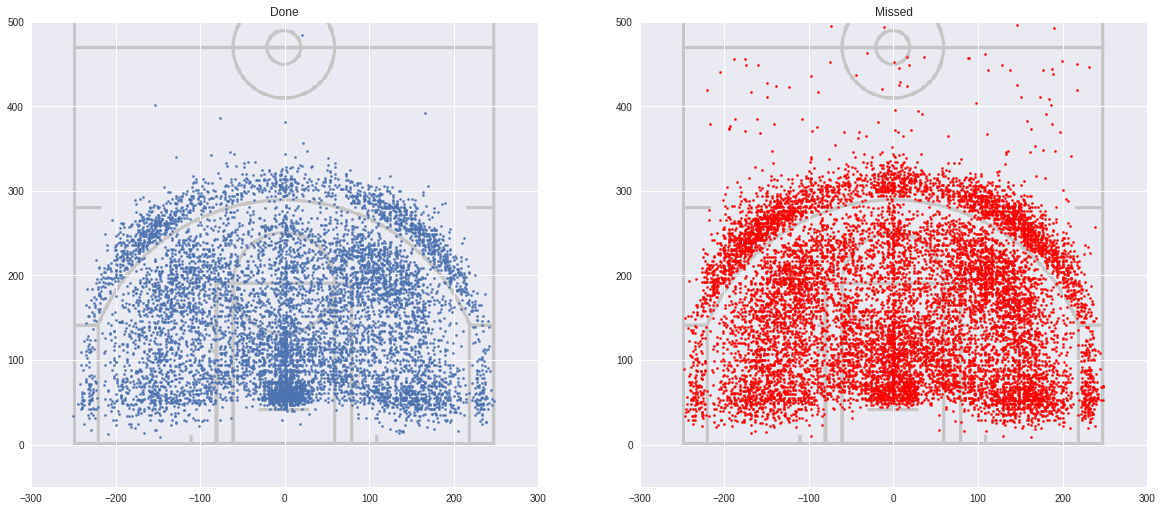

In [52]:
# http://savvastjortjoglou.com/nba-play-by-play-movements.html
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
court = plt.imread(folder + "fullcourt.png")
court = np.transpose(court, (1, 0, 2))

ax1.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax1.scatter(data['loc_x'][data['shot_made_flag'] == 1], data['loc_y'][data['shot_made_flag'] == 1] + 52.5, s=5)
ax1.set(xlim=[-300, 300], ylim=[-50, 500], aspect=1)
ax1.set_title('Done')

ax2.imshow(court, zorder=0, extent=[-250, 250, 0, 940])
ax2.scatter(data['loc_x'][data['shot_made_flag'] == 0], data['loc_y'][data['shot_made_flag'] == 0] + 52.5, s=5, color='red')
ax2.set(xlim=[-300, 300], ylim=[-50, 500], aspect=1)
ax2.set_title('Missed')

f.gca().set_aspect('equal')
f.subplots_adjust(hspace=0)
plt.show()

We drop columns with redundant location information:

* `lat, lon`
* `shot_zone_area`
* `shot_zone_range`
* `shot_zone_basic`
* `shot_distance`

They can all be represented more precisely with `[loc_x, loc_y]`. We will only keep the additional information of whether it was a 2PT or 3PT shot to account for hard to quantify psycological factors affecting the accuracy.

We also delete other redundant columns and those that do not offer relevant information for the purpose of model building (`['game_id', 'game_event_id', 'shot_id']`)

In [53]:
data.loc_x.min()

-250

In [54]:
drop_columns = ['game_id', 'game_event_id', 'team_id', 'team_name', 'lat', 'lon', 'shot_zone_area', 
                'shot_zone_range', 'shot_zone_basic', 'shot_distance', 'shot_id']
data.drop(drop_columns, axis=1, inplace=True)

In [55]:
data['three_pointer'] = (data.shot_type.str[0] == '3').astype(int)
data.drop('shot_type', axis=1, inplace=True)

# Exploratory analysis and feature selection

Here we will plot some features to recognize which ones we should consider when builing a classification model for Kobe's shots.

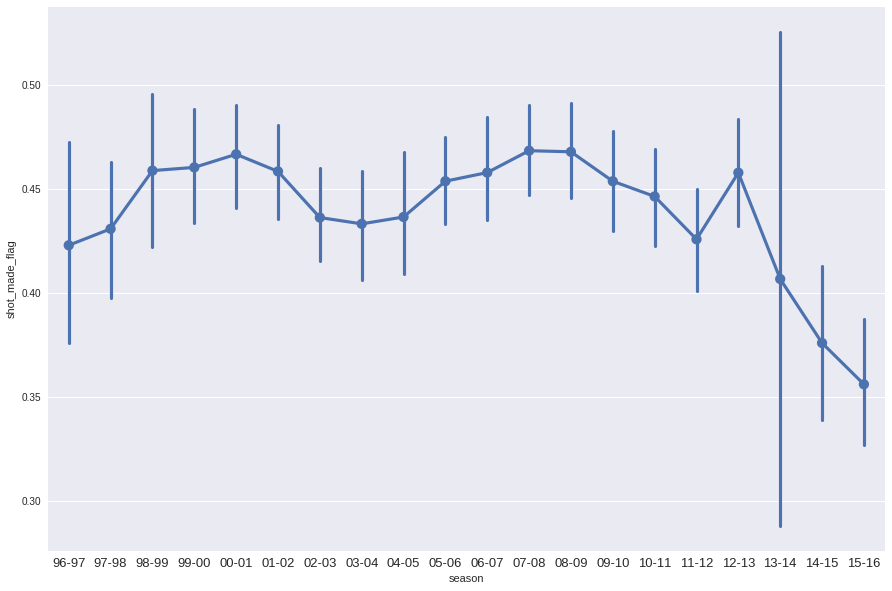

In [56]:
plt.figure(figsize=(15, 10))
ax = sns.pointplot(x='season', y='shot_made_flag', data=data, order=sorted(list(data['season'].unique())))
ax.set_xticklabels([x[2:] for x in sorted(list(data['season'].unique()))], fontsize=13)
plt.show()

The effectivity shows a very clear dependecy respect to the season. This means that the season will be a relevant feature for modelling. The big error bar for season 13-14 is due to the low number of shots Kobe took that year: he was injured during most of the season.

Let's now look at the type of shot. First we count how many shots he took of each type. The dataset has two columns with this information: `action_type` and `combined_shot_type`.

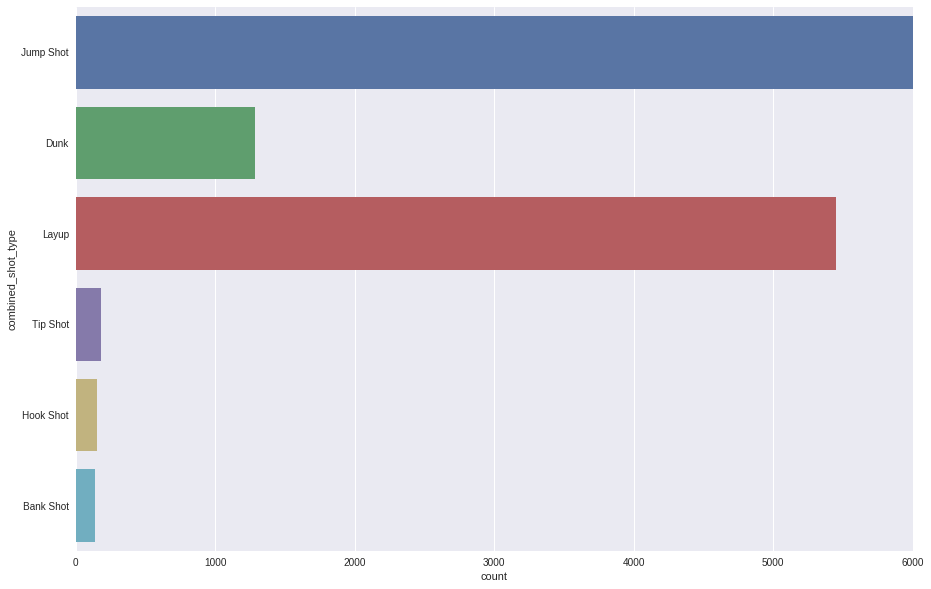

In [57]:
plt.figure(figsize=(15, 10))
sns.countplot(y='combined_shot_type', data=data)
plt.xlim(0, 6000)
plt.show()

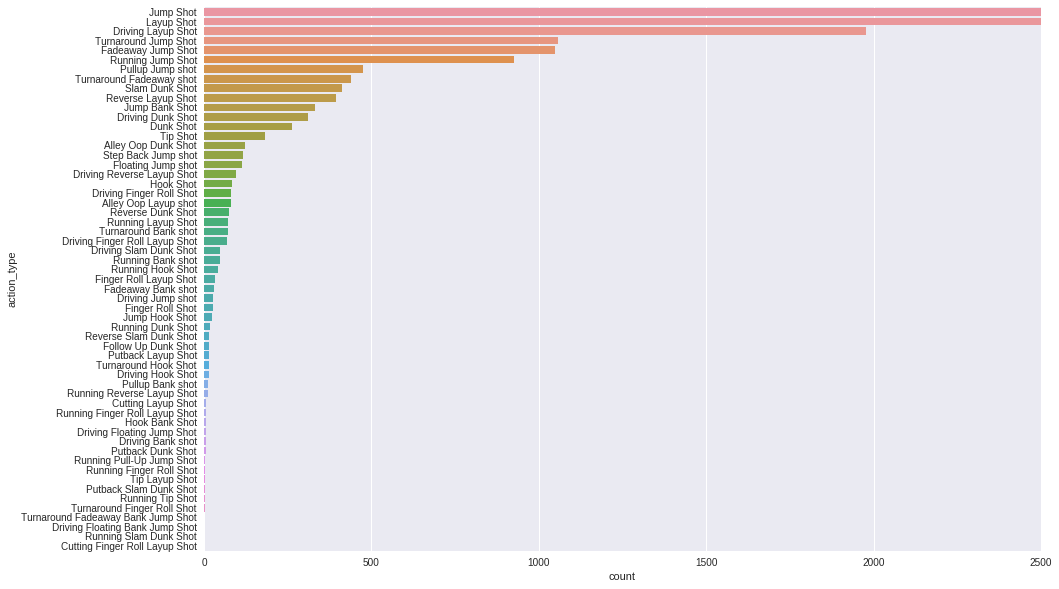

In [58]:
plt.figure(figsize=(15, 10))
sns.countplot(y='action_type', data=data, order=data['action_type'].value_counts().index)
plt.xlim(0, 2500)
plt.show()

Seems like `action_type` has a lot more information than `combined_shot_type`, because of the greater number of shot types. To avoid information redundancy, we will try to work only with `action_type` then.

Shots that were seldom used by Kobe will have no predictive value whatsover. We decide then to replace all `action_type` values with less than 100 occurrencies by the name `Other`.

In [59]:
data.loc[data.groupby('action_type').action_type.transform('count').lt(100), 'action_type'] = 'Other'   
data.action_type = data.action_type.str.replace(' Shot', '', case=False)

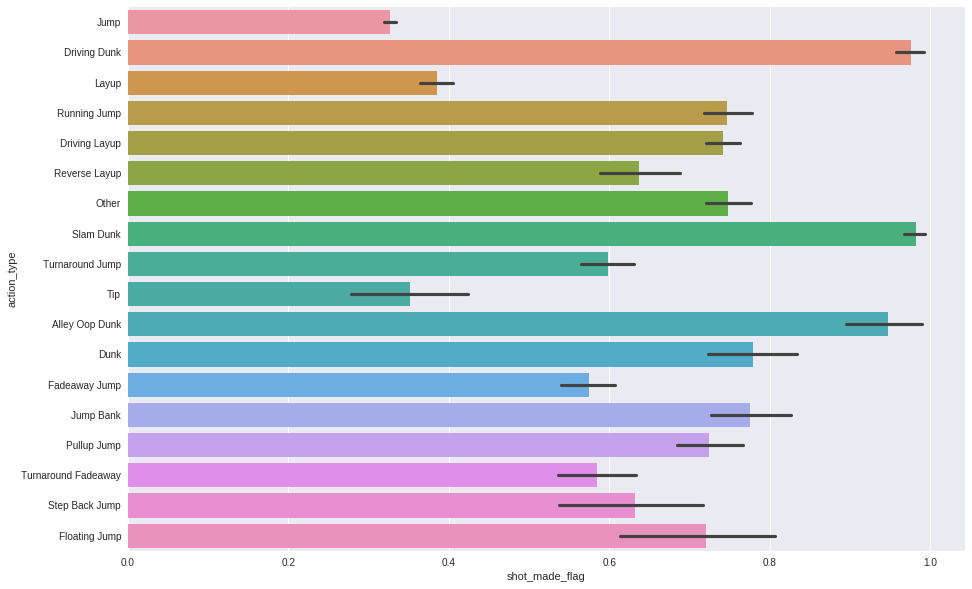

In [60]:
plt.figure(figsize=(15, 10))
sns.barplot(y='action_type', x='shot_made_flag', data=data)
plt.show()

This already looks useful. Every kind of shot seems to have a distinct effectivity, and therefore `action_type` will be an adequate feature for our model. We can now safely disregard `combined_shot_type`

In [61]:
data.drop('combined_shot_type', axis=1, inplace=True)

We only keep month information as the specific game date is not relevant. 

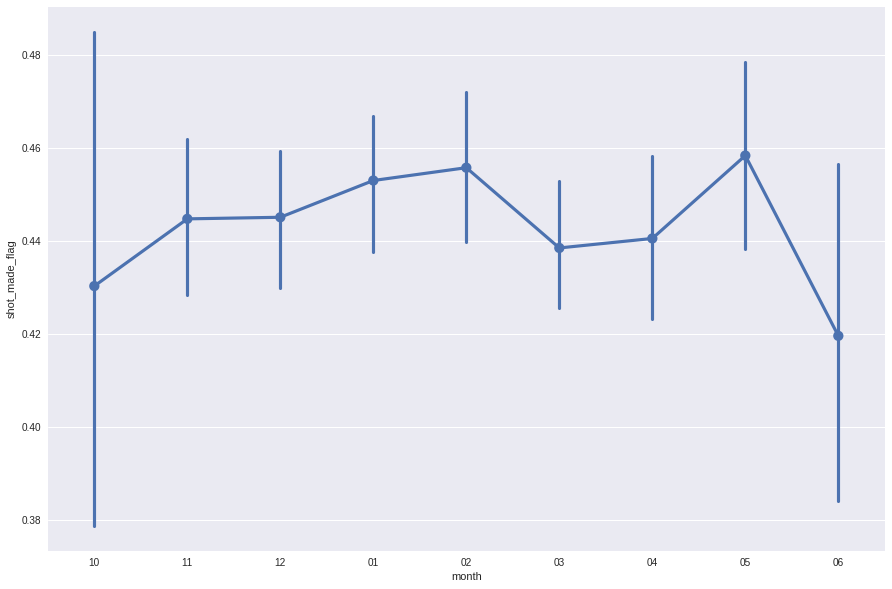

In [62]:
data['month'] = data['game_date'].str[5:7]
data.drop('game_date', axis=1, inplace=True) 

initialSeason = data.season.str[:4].astype(int).min()
data.season = data.season.str[:4].astype(int) - initialSeason

sns.pointplot(x='month', y='shot_made_flag', data=data, order=['10', '11', '12', '01', '02', '03', '04', '05', '06'])
plt.show()

Also, we need to fix the month order: some models will have a hard time dealing with the discontinuity between 12 and 1.

In [63]:
data.month.replace(data.month.unique(), np.arange(len(data.month.unique())), inplace=True)

<Figure size 1080x720 with 0 Axes>

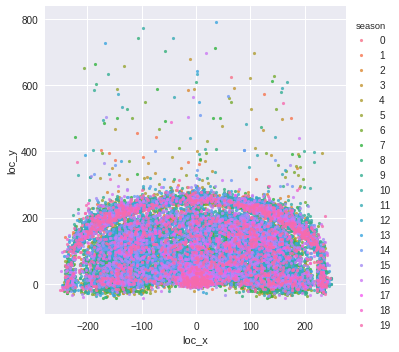

In [64]:
plt.figure(figsize=(15, 10))
sns.lmplot(x='loc_x', y='loc_y', data=data, hue='season', fit_reg=False, 
           scatter_kws={"marker": "D", "s": 10})
plt.show()

`minutes_remaining` and `seconds_remaining` can be merged into a single feature that we will call `time_remaining` and we will measure in seconds

In [65]:
data['time_remaining'] = data.minutes_remaining*60 + data.seconds_remaining
data.drop(['minutes_remaining', 'seconds_remaining'], axis=1, inplace=True)

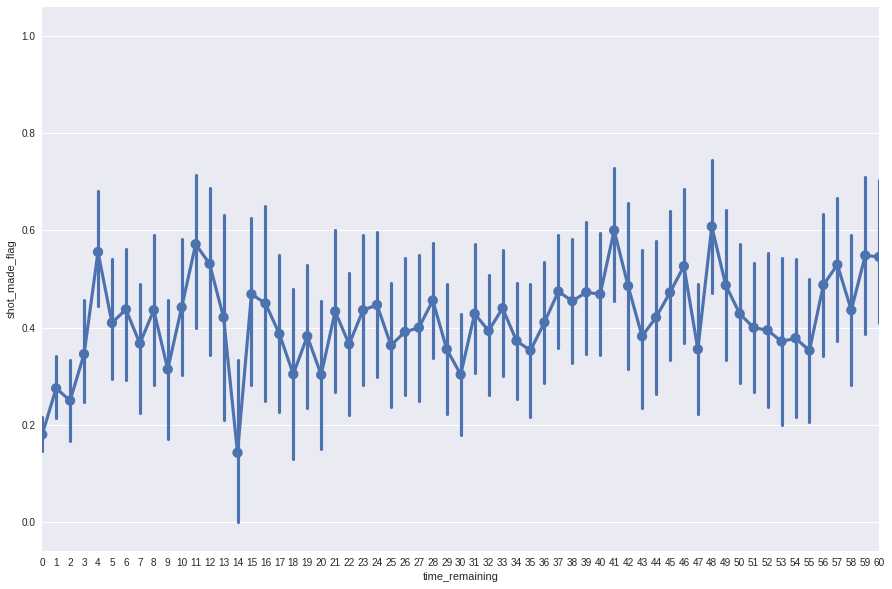

In [66]:
plt.figure(figsize=(15, 10))
ax = sns.pointplot(x='time_remaining', y='shot_made_flag', data=data)
ax.set_xlim(0, 60)
plt.show()

We see the effectivity is fairly constant except for the last minute shots. In order to keep this information while still reducing the number of features, we discretize `time_remaining` in `0, 1, 2, 3, 4`, where `4` also includes all shots taken with more than 4 seconds remaining on the clock.

In [67]:
data.time_remaining.loc[data.time_remaining > 3] = 4

/home/federico/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


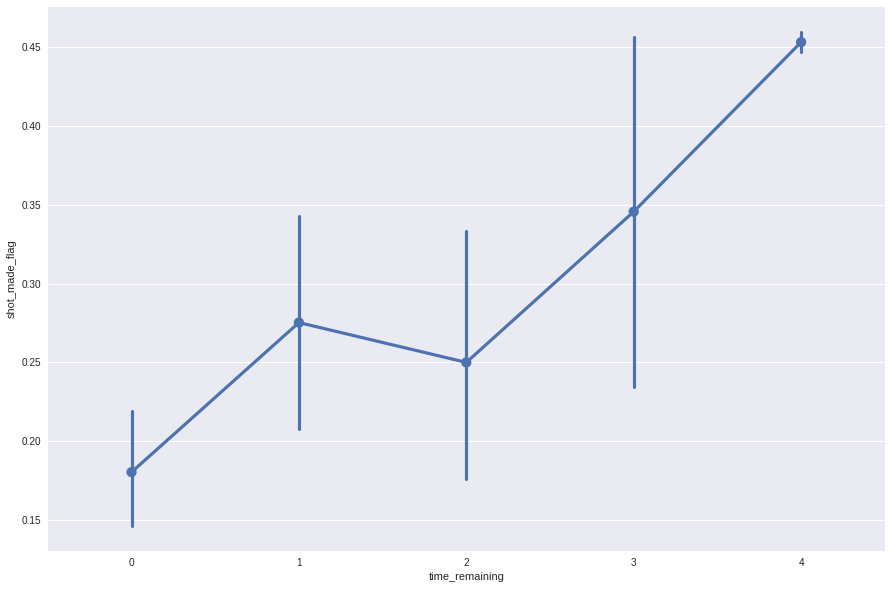

In [68]:
sns.pointplot(x='time_remaining', y='shot_made_flag', data=data)
plt.show()

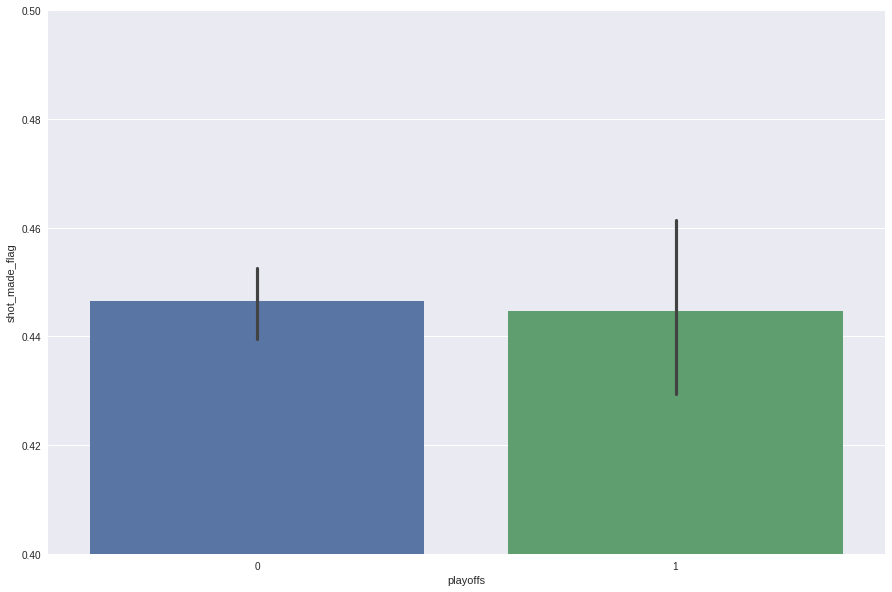

In [69]:
sns.barplot(x='playoffs', y='shot_made_flag', data=data)
plt.ylim(0.4, 0.5)
plt.show()

Whether the game is part of the playoffs phase does not seem to affect Kobe's shot effectivity. We can therefore remove this input feature from the dataset.

In [70]:
data.drop('playoffs', axis=1, inplace=True)

We simplify game location and opponent information

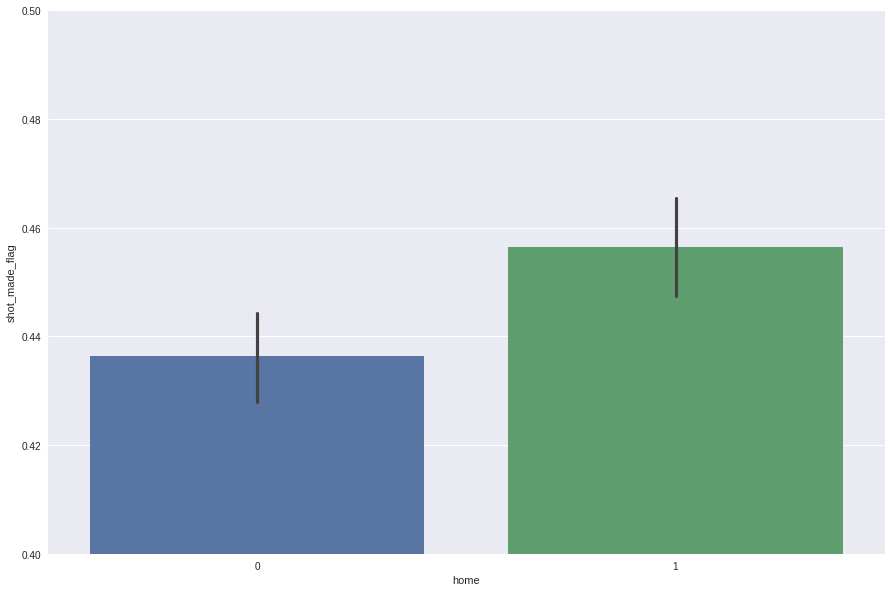

In [71]:
data['home'] = data['matchup'].str.contains('vs').astype(int)
data.drop('matchup', axis=1, inplace=True)

sns.barplot(x='home', y='shot_made_flag', data=data)
plt.ylim(0.4, 0.5)
plt.show()

In contrast to the `playoffs` case, here we see a clear difference between home and away games: Kobe is slightly more effective when at home, and therefore we will keep `home` as a feature.

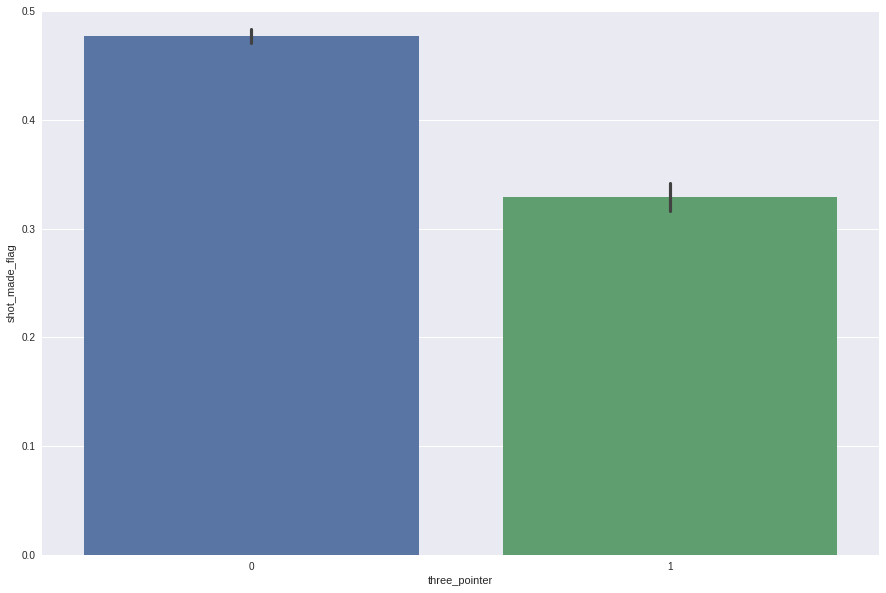

In [72]:
sns.barplot(x='three_pointer', y='shot_made_flag', data=data)
plt.ylim(0, 0.5)
plt.show()

As expected, three-point shots have a lower effectivity than two-point shots.

In [73]:
data.shot_made_flag.isnull().sum()

5000

We don't know the outcome of 5000 shots, so we'll delete those rows

In [74]:
data = data[~data.shot_made_flag.isnull()]

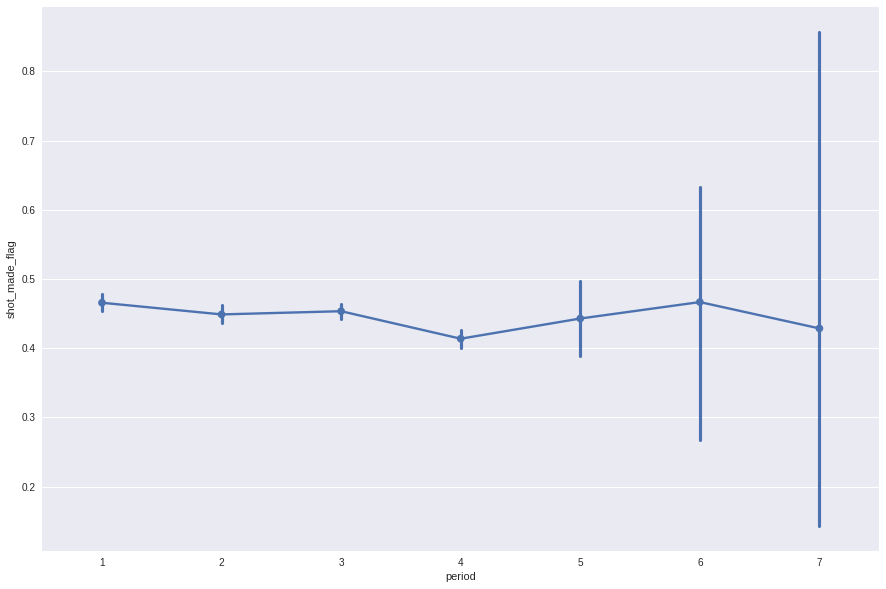

In [75]:
sns.pointplot(x='period', y='shot_made_flag', data=data, scale=0.75)
plt.show()

The big error bars are due to the low number of shots taken from overtime periods. Let's merge them into a single period datapoint. 

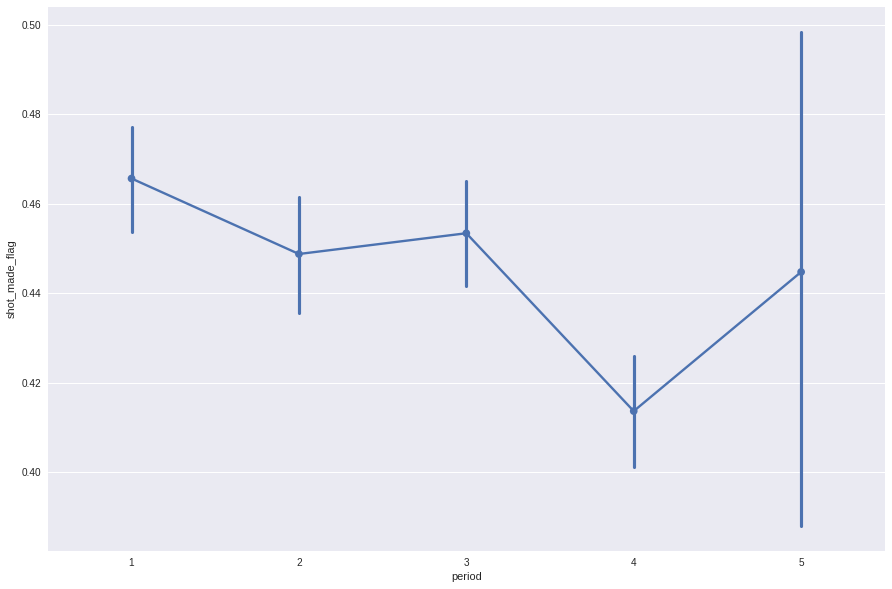

In [76]:
data.period.loc[data.period > 4] = 5
sns.pointplot(x='period', y='shot_made_flag', data=data, scale=0.75)
plt.show()

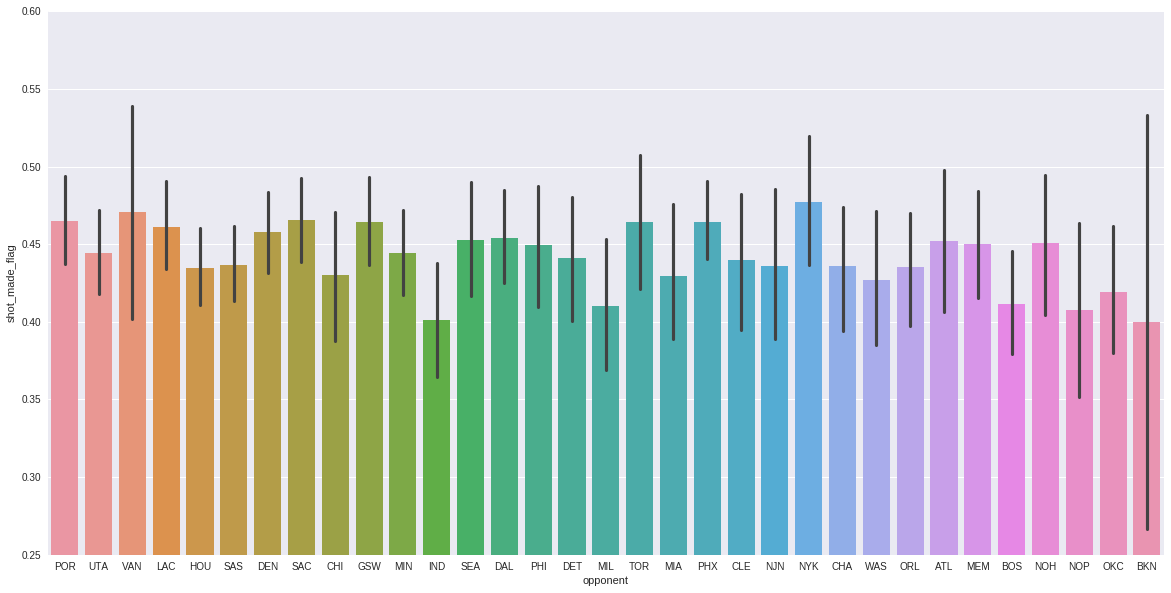

In [77]:
plt.figure(figsize=(20, 10))
sns.barplot(x='opponent', y='shot_made_flag', data=data)
plt.ylim(0.25, 0.6)
plt.show()

Theres does not seem to be any information here. Kobe's effectivity values against all teams are well within the error bars. Therefore, we won't include this feature in the model.

The polar coordinate system offers a more natural representation for the shot location in cartesian coordinates. It will likely lead to a more robust model. Let's transform the coordiantes then.

In [78]:
data['distance'] = np.sqrt(data.loc_x**2 + data.loc_y**2)
data['angle'] = np.arctan(data.loc_x/data.loc_y)
data['angle'].fillna(0, inplace=True)

/home/federico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctan
  


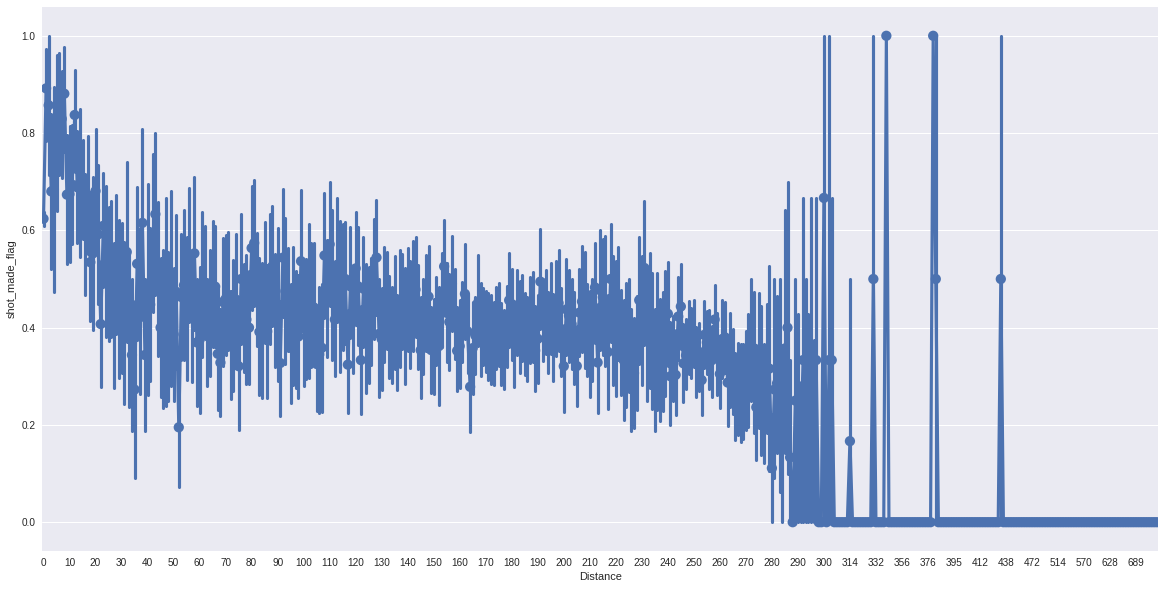

In [79]:
fig = plt.figure(figsize=(20, 10))
sns.pointplot(x=data.distance.astype(int), y='shot_made_flag', data=data)

# Overlapping labels fix
labels = fig.gca().get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%10 != 0): 
        labels[i] = ''
fig.gca().set_xticklabels(labels)

plt.xlabel('Distance')
plt.show()

The signal here is very noisy, but if we take a moving average, we see the effectivity peaks at distances closest to the basket and then there is a plateau that transitions into a slow decrease for shots taken far from the basket.

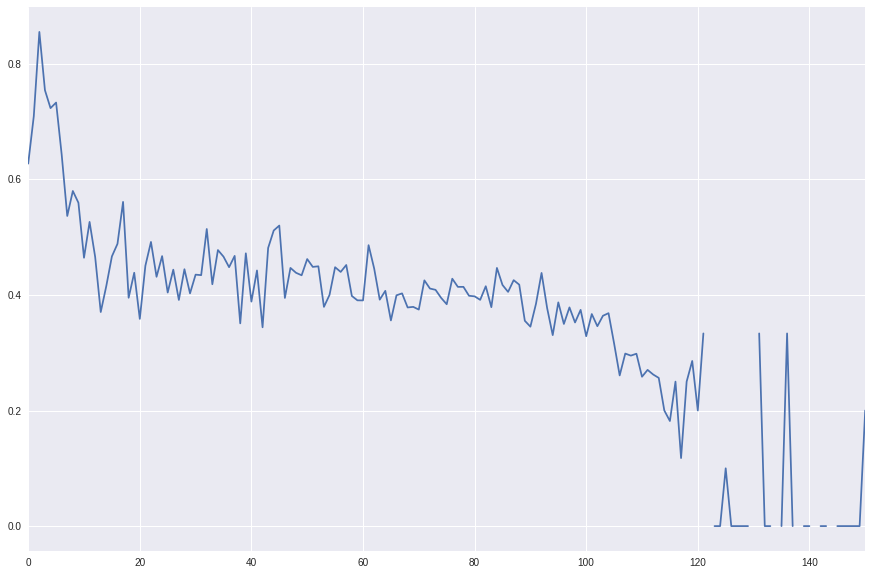

In [80]:
data['distance_binned'] = pd.cut(data.distance, data.distance.max()/2.5)

plt.plot(data.groupby('distance_binned').shot_made_flag.mean().reset_index().shot_made_flag)
plt.xlim(0, 150)
plt.show()

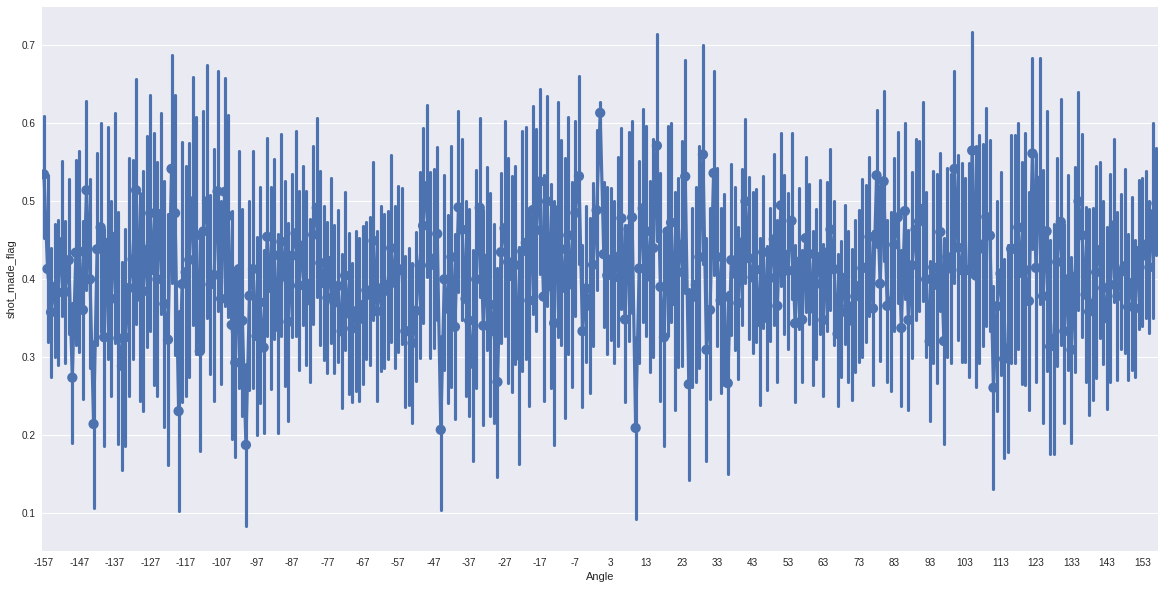

In [81]:
fig = plt.figure(figsize=(20, 10))
sns.pointplot(x=(100*data.angle).astype(int), y='shot_made_flag', data=data)

# Overlapping labels fix
labels = fig.gca().get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%10 != 0): 
        labels[i] = ''
fig.gca().set_xticklabels(labels)

plt.xlabel('Angle')
plt.show()

This is surprising: the shot of the angle does not seems to have an effect on the effectivity. It seems like a good idea not to include it in our model.

In [82]:
data.sample(10)

,action_type,loc_x,loc_y,period,season,shot_made_flag,opponent,three_pointer,month,time_remaining,home,distance,angle,distance_binned
15616,Pullup Jump,65,121,1,13,1.0,DAL,0,3,4,1,137.353558,0.492955,"(135.311, 137.817]"
17288,Jump,119,143,3,14,1.0,DEN,0,3,4,0,186.037631,0.694050,"(185.426, 187.932]"
21825,Jump,63,72,1,19,0.0,DAL,0,1,4,1,95.671312,0.718830,"(95.219, 97.724]"
27021,Dunk,0,0,1,6,1.0,MIN,0,6,4,0,0.000000,0.000000,"(-0.792, 2.506]"
9614,Jump,-125,217,2,9,1.0,GSW,1,6,4,1,250.427634,-0.522613,"(248.07, 250.576]"
8985,Jump,151,232,4,9,0.0,ORL,1,4,4,1,276.812211,0.576981,"(275.633, 278.139]"
21536,Jump,-98,162,3,18,0.0,NOP,0,2,4,1,189.335681,-0.544043,"(187.932, 190.437]"
18736,Jump,56,241,3,15,1.0,TOR,1,4,4,0,247.420694,0.228314,"(245.564, 248.07]"
29914,Jump,204,123,3,15,0.0,OKC,1,7,4,0,238.212090,1.028217,"(238.047, 240.553]"
5518,Jump,-166,-13,2,7,1.0,MIN,0,3,4,0,166.508258,1.492643,"(165.38, 167.886]"


## Modelling Kobe

Based on the analysis of each feature done in the previous section, we select the most relevant ones for modelling Kobe's effectivity.

In [83]:
X = data[['action_type', 'period', 'season', 'three_pointer', 'month', 'time_remaining', 'home', 'distance']]
y = data['shot_made_flag']

In [84]:
X.head()

,action_type,period,season,three_pointer,month,time_remaining,home,distance
1,Jump,1,4,0,0,4,0,157.000000
2,Jump,1,4,0,0,4,0,168.600119
3,Jump,1,4,0,0,4,0,222.865430
4,Driving Dunk,2,4,0,0,4,0,0.000000
5,Jump,3,4,0,0,4,0,145.416643


We are almost there. 

We need to encode cathegorical features into numerical ones, so that they can be picked up by a model. Following [this guide](http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example)

In [85]:
dummies = pd.get_dummies(X.action_type, prefix='shot', drop_first=True)

X = pd.concat([X, dummies],axis=1)

# now we drop the original action_type column
X.drop(['action_type'], axis=1, inplace=True)

In [86]:
X.head()

,period,season,three_pointer,month,time_remaining,home,distance,shot_Driving Dunk,shot_Driving Layup,shot_Dunk,...,shot_Layup,shot_Other,shot_Pullup Jump,shot_Reverse Layup,shot_Running Jump,shot_Slam Dunk,shot_Step Back Jump,shot_Tip,shot_Turnaround Fadeaway,shot_Turnaround Jump
1,1,4,0,0,4,0,157.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,0,4,0,168.600119,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,0,0,4,0,222.865430,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,4,0,0,4,0,0.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,4,0,0,4,0,145.416643,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our dataset is now ready to

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [93]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()  
rf.fit(X_train, y_train)  
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train), reverse=True))

Features sorted by their score:
[(0.4682, 'distance'), (0.1836, 'season'), (0.1211, 'month'), (0.0589, 'period'), (0.047, 'shot_Jump'), (0.0191, 'shot_Layup'), (0.0184, 'home'), (0.0114, 'shot_Driving Layup'), (0.01, 'time_remaining'), (0.01, 'shot_Slam Dunk'), (0.0081, 'shot_Running Jump'), (0.0072, 'shot_Other'), (0.0064, 'shot_Driving Dunk'), (0.0056, 'three_pointer'), (0.0044, 'shot_Pullup Jump'), (0.0036, 'shot_Turnaround Jump'), (0.0034, 'shot_Jump Bank'), (0.0032, 'shot_Tip'), (0.0028, 'shot_Fadeaway Jump'), (0.0025, 'shot_Dunk'), (0.0017, 'shot_Turnaround Fadeaway'), (0.0017, 'shot_Reverse Layup'), (0.0012, 'shot_Step Back Jump'), (0.0006, 'shot_Floating Jump')]


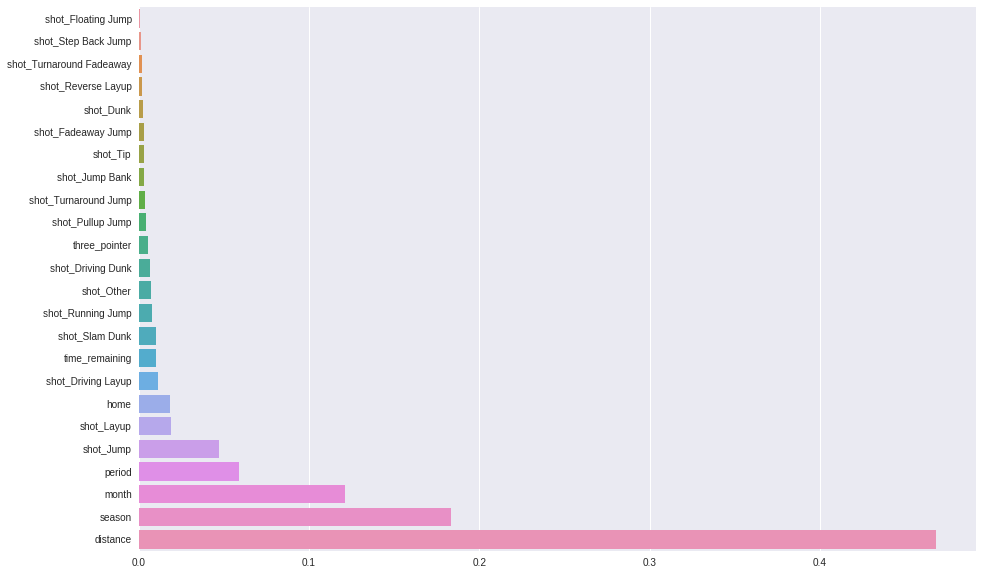

In [109]:
feat_importances = [x for _,x in sorted(zip(rf.feature_importances_, X_train))]
sns.barplot(np.sort(rf.feature_importances_), feat_importances)

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 
          'LinearDiscriminantAnalysis', 'GaussianNB', 'SVC']
accuracies = []
accuracies_test = []
for model in models:
    classifier = globals()[model]()
    classifier.fit(X_train, y_train)
    Y_pred = classifier.predict(X_test)
    accuracies.append(classifier.score(X_train, y_train) * 100)
    accuracies_test.append(classifier.score(X_test, y_test) * 100)

LogisticRegression
DecisionTreeClassifier
RandomForestClassifier
KNeighborsClassifier
LinearDiscriminantAnalysis
GaussianNB
SVC


In [124]:
accuracies

[67.91360607092474,
 97.83528725008513,
 95.07223816704771,
 73.08459405555286,
 67.9281996400253,
 66.76557863501483,
 69.70861507029235]

In [125]:
accuracies_test

[68.59922178988327,
 58.871595330739304,
 63.34630350194552,
 59.45525291828794,
 68.57976653696498,
 67.04280155642023,
 66.36186770428016]

In [167]:
rf = RandomForestClassifier(n_estimators=100, max_depth=11)
rf.fit(X_train, y_train)
Y_pred = rf.predict(X_test)
print('accuracy ', rf.score(X_train, y_train) * 100)
print('accuracy test ', rf.score(X_test, y_test) * 100)

accuracy  69.79131196186214
accuracy test  68.6964980544747
